In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore 
from scipy.sparse.linalg import eigsh

from skimage.measure import block_reduce
from sklearn.cluster import KMeans


import sys
sys.path.append('../utils')
sys.path.append('../dFC')
import widefield_utils
import connectivity_measures
import os

In [2]:
final_mask = np.load(r"/home/k21208334/calcium_analyses/data/dowsampled_tight_mask.npy")
good_indices = np.ravel(final_mask)

h=300
w=304
H = 50
W = 51

start = 0
end = 25000

window_size = 30
# n_comp = 10 #number of ICA components
n_comp = 20

names = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]


path = '/home/k21208334/calcium_analyses/data/leading_eigenvectors/window_size=' + str(window_size) + '/'


In [3]:
eigenvectors_all = np.empty((0,np.sum(final_mask))) # to change this!!!!!

# load clustered data 

for name in names+names_knock:

    data = path + name + ".npy"
    centr = np.load(data)
    eigenvectors_all = np.vstack((eigenvectors_all,centr))

In [4]:
n_comp_T = 20

spatial_comps = np.load(path + 'ICA_T_signals_n_comp=' + str(n_comp_T) + '.npy')
temporal_comps = np.load(path + 'ICA_T_components_n_comp=' + str(n_comp_T) + '.npy')

In [5]:
# transpose clustering...let's see what happens
from sklearn.cluster import KMeans
k = 8

km = KMeans(n_clusters=k)
km = km.fit(temporal_comps)

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


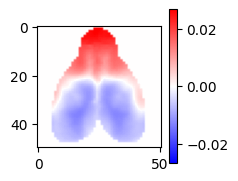

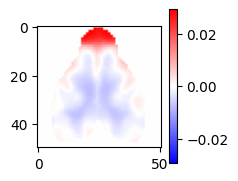

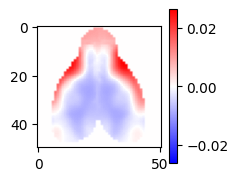

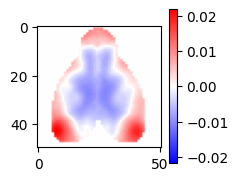

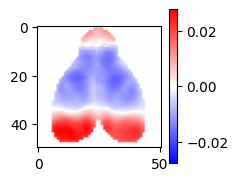

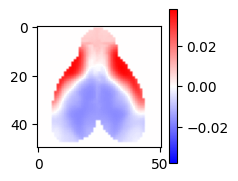

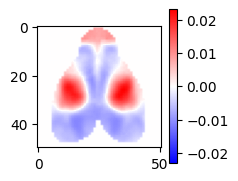

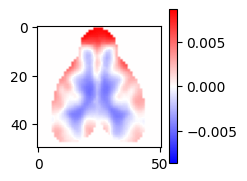

In [6]:
cluster_centers = km.cluster_centers_
centroids = np.dot(spatial_comps,cluster_centers.T)

for i,centroid in enumerate(centroids.T):
    fig = connectivity_measures.show_array(centroid,H,W,good_indices,(-np.abs(centroid).max(),np.abs(centroid).max()))
    fig.set_size_inches(2,2)

In [7]:
# i have to save labels, centroids and signatures 

for i,name in enumerate(names+names_knock):
    timeseries_labels = km.labels_[int(i*end):int((i+1)*end)]
    np.save(path+name+'_k='+str(k)+'_ica_T='+str(n_comp_T)+'_labels',timeseries_labels)

np.save(path+'k='+str(k)+'_ica_T='+str(n_comp_T)+'_centroids',centroids)

In [8]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

cluster_centers = km.cluster_centers_
centroids = np.dot(spatial_comps,cluster_centers.T)

def do_statistics(centroids,H,W,good_indices,measure_walk,measure_rest,measure_all,title,speed):

    for i,centroid in enumerate(centroids.T):
        fig = connectivity_measures.show_array(centroid,H,W,good_indices,(-np.abs(centroid).max(),np.abs(centroid).max()))
        fig.set_size_inches(2,2)
    
        fig,ax = plt.subplots(1,5,sharey=True)
        fig.set_size_inches(8,2)
        ax[0].boxplot([measure_walk[0:6,i],measure_walk[6:12,i]])
        test = mannwhitneyu(measure_walk[0:6,i],measure_walk[6:12,i])
        pvalue = test.pvalue
        ax[0].set_title('walk p=, '+str(round(pvalue,3)),fontsize=10)
        ax[0].set_xticks([1,2], ['wild','KO'])
        ax[0].set_ylabel(title)
    
        ax[1].boxplot([measure_rest[0:6,i],measure_rest[6:12,i]])
        test = mannwhitneyu(measure_rest[0:6,i],measure_rest[6:12,i])
        pvalue = test.pvalue
        ax[1].set_title('rest p=, '+str(round(pvalue,3)),fontsize=10)
        ax[1].set_xticks([1,2], ['wild','KO'])
    
        # try also statistics on walk vs non walk as a control...
        ax[2].plot([measure_rest[0:6,i],measure_walk[0:6,i]],color='black')
        ax[2].plot([measure_rest[6:12,i],measure_walk[6:12,i]],color='red')
        test = wilcoxon(measure_rest[:,i],measure_walk[:,i])
        pvalue = test.pvalue
        ax[2].set_title('rest/walk p='+str(round(pvalue,3)),fontsize=10)
        ax[2].set_xticks([0,1], ['rest','walk'])
        fig.tight_layout()

        x = np.squeeze(speed.T)
        y = measure_all[:,i]
        ax[3].scatter(x,y)
        slope, intercept = np.polyfit(x, y, 1)
        corr_coef = np.corrcoef(x, y)[0, 1]
        # Add the linear fit line to the plot
        ax[3].plot(x, slope*x + intercept, color='red')
        ax[3].set_title(f'R: {corr_coef:.2f}',fontsize=10)
        ax[3].set_xlabel('average speed')
    
        differences = measure_walk-measure_rest
        test = mannwhitneyu(differences[0:6,i],differences[6:12,i])
        pvalue = test.pvalue
        ax[4].boxplot([differences[0:6,i],differences[6:12,i]])
        ax[4].set_title('walk-rest p='+str(round(pvalue,3)),fontsize=10)
        ax[4].set_xticks([1,2], ['wild','KO'])
    


In [9]:
def do_statistics_wild_ko(centroids,H,W,good_indices,measure_walk,measure_rest,measure_all,title,speed):

    for i,centroid in enumerate(centroids.T):
        fig = connectivity_measures.show_array(centroid,H,W,good_indices,(-np.abs(centroid).max(),np.abs(centroid).max()))
        fig.set_size_inches(2,2)
        plt.xticks([])
        plt.yticks([])
    
        fig,ax = plt.subplots(1,2)
        fig.set_size_inches(6,2)
        ax[0].boxplot([measure_walk[0:6,i],measure_walk[6:12,i],measure_rest[0:6,i],measure_rest[6:12,i]])
        test = mannwhitneyu(measure_walk[0:6,i],measure_walk[6:12,i])
        pvalue1 = test.pvalue
        test = mannwhitneyu(measure_rest[0:6,i],measure_rest[6:12,i])
        pvalue2 = test.pvalue
        ax[0].set_xticks([1,2,3,4], ['wild-walk','KO-walk','wild-rest','KO-rest'])
        ax[0].set_title('walk p=, '+str(round(pvalue1,3))+'rest p=, '+str(round(pvalue2,3)),fontsize=10)
        ax[0].set_ylabel(title)
   
        differences = measure_walk-measure_rest
        test = mannwhitneyu(differences[0:6,i],differences[6:12,i])
        pvalue = test.pvalue
        ax[1].boxplot([differences[0:6,i],differences[6:12,i]])
        ax[1].set_title('walk-rest p='+str(round(pvalue,3)),fontsize=10)
        ax[1].set_xticks([1,2], ['wild','KO'])

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def do_statistics_wild_ko(centroids, H, W, good_indices, measure_walk, measure_rest, measure_all, title, speed):
    for i, centroid in enumerate(centroids.T):
        fig = connectivity_measures.show_array(centroid, H, W, good_indices, (-np.abs(centroid).max(), np.abs(centroid).max()))
        fig.set_size_inches(2, 2)
        plt.xticks([])
        plt.yticks([])

        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(7, 2)
        
        colors = ['#808080', '#FF0000', '#808080', '#FF0000', '#808080', '#FF0000']
        
        bp_walk = ax[0].boxplot([measure_walk[0:6, i], measure_walk[6:12, i], measure_rest[0:6, i], measure_rest[6:12, i]], patch_artist=True)
        for box, color in zip(bp_walk['boxes'], colors):
            box.set_facecolor(color)
        
        test = mannwhitneyu(measure_walk[0:6, i], measure_walk[6:12, i])
        pvalue1 = test.pvalue
        test = mannwhitneyu(measure_rest[0:6, i], measure_rest[6:12, i])
        pvalue2 = test.pvalue
        ax[0].set_xticks([1.5, 3.5])
        ax[0].set_xticklabels(['walk', 'rest'])
        ax[0].set_title('walk p={}, rest p={}'.format(round(pvalue1, 3), round(pvalue2, 3)), fontsize=10)
        ax[0].set_ylabel(title)

        differences = measure_walk - measure_rest
        test = mannwhitneyu(differences[0:6, i], differences[6:12, i])
        pvalue = test.pvalue
        bp_rest = ax[1].boxplot([differences[0:6, i], differences[6:12, i]], patch_artist=True)
        for box, color in zip(bp_rest['boxes'], colors):
            box.set_facecolor(color)
        
        ax[1].set_title('walk-rest p={}'.format(round(pvalue, 3)), fontsize=10)
        ax[1].set_xticks([1, 2])
        ax[1].set_xticklabels(['wild', 'KO'])
        
    plt.show()



In [11]:
def do_statistics_walk(centroids, H, W, good_indices, measure_walk, measure_rest, measure_all, title, speed):
    for i, centroid in enumerate(centroids.T):
        fig = connectivity_measures.show_array(centroid, H, W, good_indices, (-np.abs(centroid).max(), np.abs(centroid).max()))
        ## Remove x and y ticks from the current axes
        plt.xticks([])
        plt.yticks([])
        fig.set_size_inches(2, 2)

        fig, ax = plt.subplots(1, 2, sharey=True)
        fig.set_size_inches(4, 2)  

        # plot for rest/walk comparison
        ax[0].plot([measure_rest[0:6,i],measure_walk[0:6,i]],color='black')
        ax[0].plot([measure_rest[6:12,i],measure_walk[6:12,i]],color='red')
        test = wilcoxon(measure_rest[:,i],measure_walk[:,i])
        pvalue = test.pvalue
        ax[0].set_title('p='+str(round(pvalue,5)),fontsize=10)
        ax[0].set_xticks([0,1], ['rest','walk'])
        ax[0].set_ylabel(title)
        fig.tight_layout()

        # Scatter plot for average speed vs. measure_all
        x = np.squeeze(speed.T)
        y = measure_all[:, i]
        ax[1].scatter(x, y, c='blue', alpha=0.7)
        slope, intercept = np.polyfit(x, y, 1)
        corr_coef = np.corrcoef(x, y)[0, 1]
        ax[1].plot(x, slope * x + intercept, color='red', linewidth=2)
        ax[1].set_title(f'R= {corr_coef:.2f}', fontsize=10)
        ax[1].set_xlabel('Average Speed')
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)

        # Adjust spacing between subplots
        fig.tight_layout()

        # Show the plot
        plt.show()



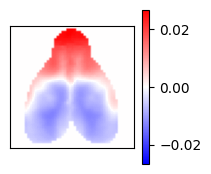

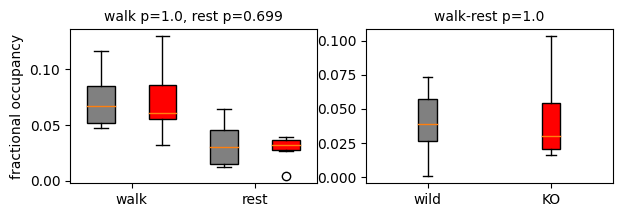

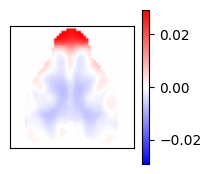

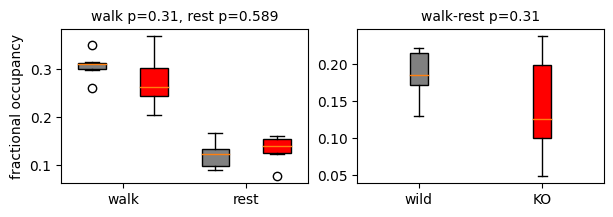

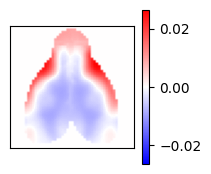

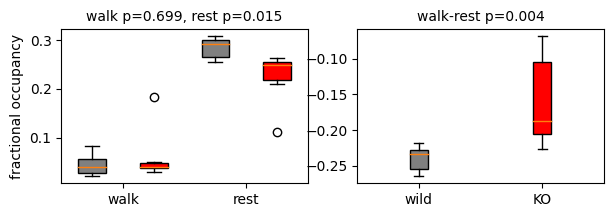

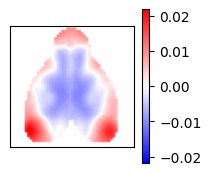

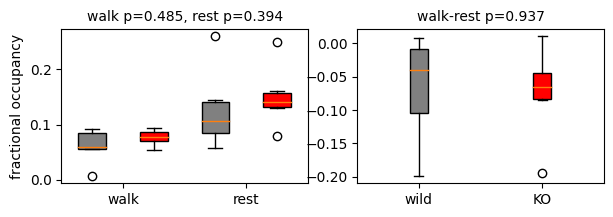

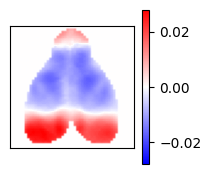

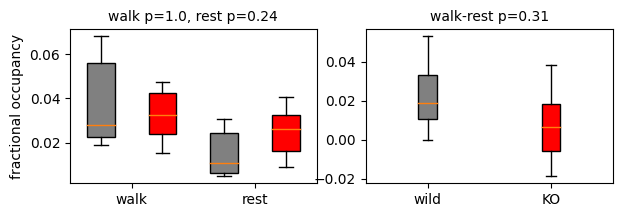

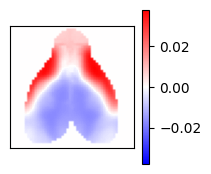

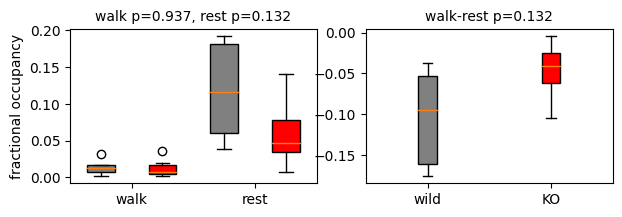

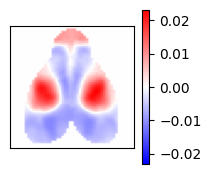

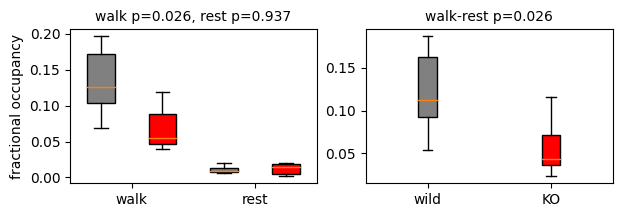

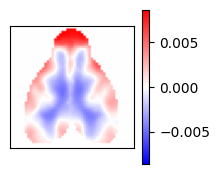

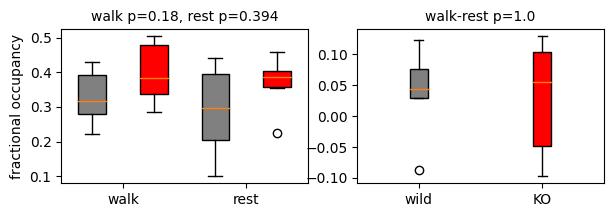

In [12]:
# let's define fractional occupancies. REALITY is just a dream which is good enough to make us survive.

n_individuals = len(names+names_knock)
fractional_occupancies_walk = np.zeros((n_individuals,k))
fractional_occupancies_rest = np.zeros((n_individuals,k))
fractional_occupancies_all = np.zeros((n_individuals,k))
avg_abs_speed = np.zeros((n_individuals,1))

for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        timeseries_labels = km.labels_[int(i*end):int((i+1)*end)]==j
        fractional_occupancies_walk[i,j] = np.sum(timeseries_labels[walking])/len(timeseries_labels[walking])
        fractional_occupancies_rest[i,j] = np.sum(timeseries_labels[~walking])/len(timeseries_labels[~walking])
        fractional_occupancies_all[i,j] = np.sum(timeseries_labels)/end
    avg_abs_speed[i] = np.mean(np.abs(np.load('/home/k21208334/calcium_analyses/data/raw_speed/'+name+'.npy')))
    
do_statistics_wild_ko(centroids,H,W,good_indices,fractional_occupancies_walk,fractional_occupancies_rest,fractional_occupancies_all,'fractional occupancy',avg_abs_speed)

In [13]:
# DEFINITION OF THE FUNCTION. WHEN READY, TRANSFER TO LIBRARY
def compute_dwell_time(labels,walking,threshold):
    dwell_times = []
    walking_bouts = widefield_utils.get_connected_components(walking,threshold)
    for bout in walking_bouts:
        labels_bout = widefield_utils.get_connected_components(labels[bout],0) # this threshold at the moment is 0, whatever duration is accepted
        for element in labels_bout:
            dwell_times.append(len(element))
    if len(dwell_times)>0:
        result = np.mean(dwell_times)
    else:
        result = 0
    return result

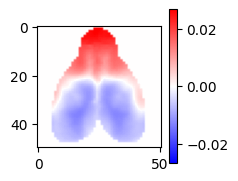

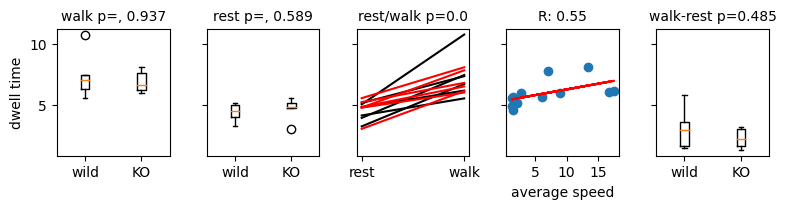

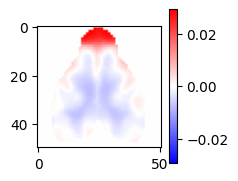

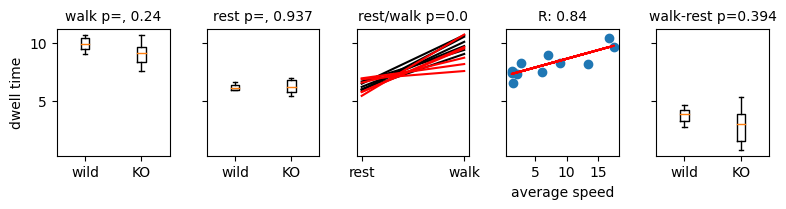

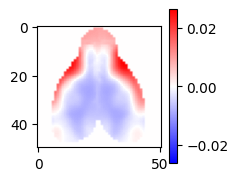

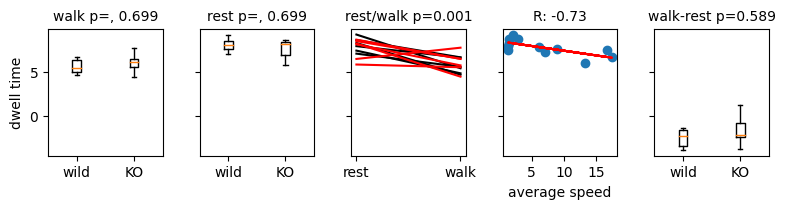

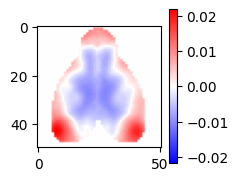

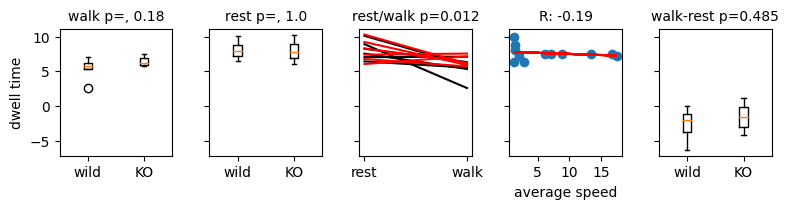

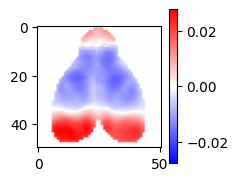

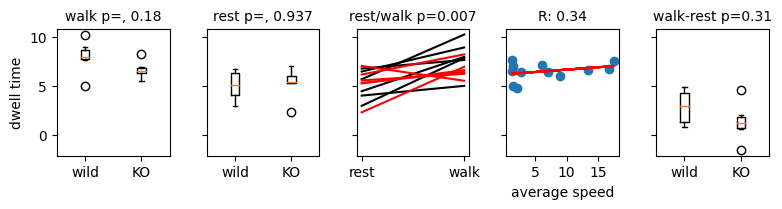

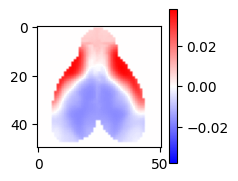

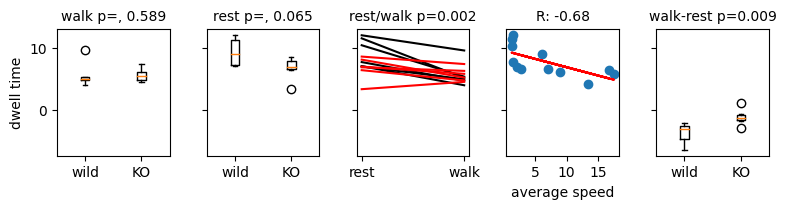

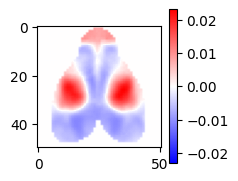

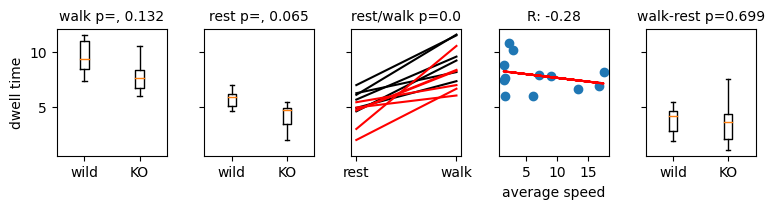

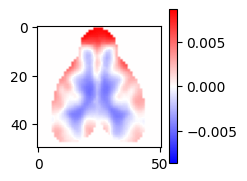

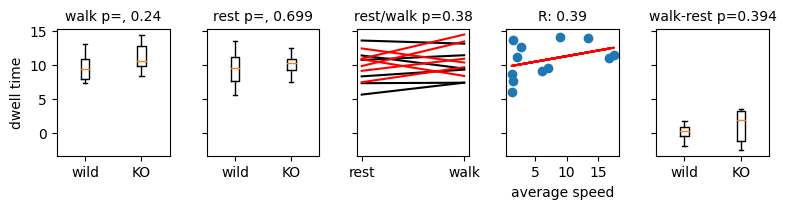

In [14]:
# let us now define dwell time. With a similar code. When everything is set and well done, we transfer to functions

threshold = 36 # i want a bout of at least 1 second in order to consider it as a reliable walk/rest period

n_individuals = len(names+names_knock)
dwell_times_walk = np.zeros((n_individuals,k))
dwell_times_rest = np.zeros((n_individuals,k))
dwell_times_all = np.zeros((n_individuals,k))
avg_abs_speed = np.zeros((n_individuals,1))

for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        timeseries_labels = km.labels_[int(i*end):int((i+1)*end)]==j
        dwell_times_walk[i,j] = compute_dwell_time(timeseries_labels,walking,threshold)
        dwell_times_rest[i,j] = compute_dwell_time(timeseries_labels,~walking,threshold)
        dwell_times_all[i,j] = compute_dwell_time(timeseries_labels,np.array([True] * end),threshold)
    avg_abs_speed[i] = np.mean(np.abs(np.load('/home/k21208334/calcium_analyses/data/raw_speed/'+name+'.npy')))

do_statistics(centroids,H,W,good_indices,dwell_times_walk,dwell_times_rest,dwell_times_all,'dwell time',avg_abs_speed)

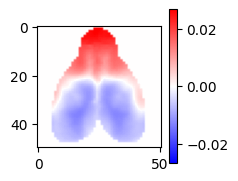

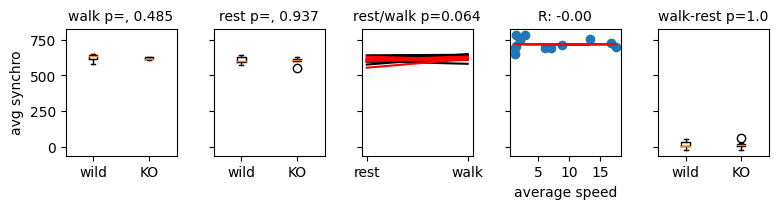

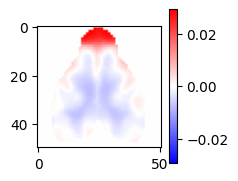

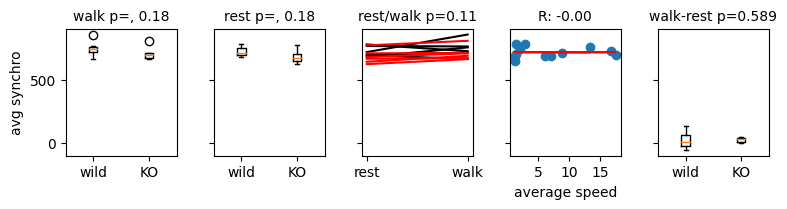

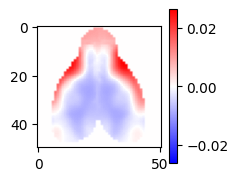

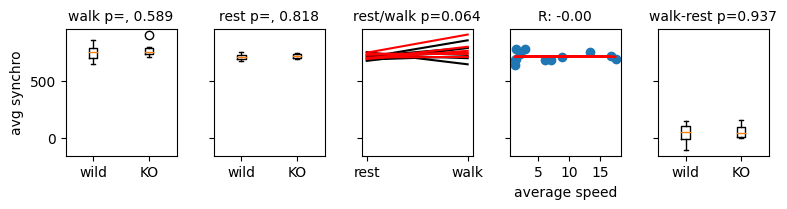

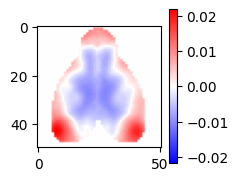

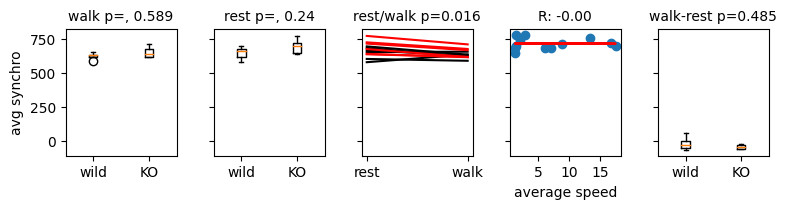

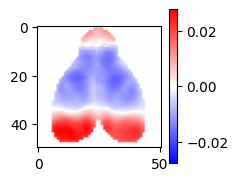

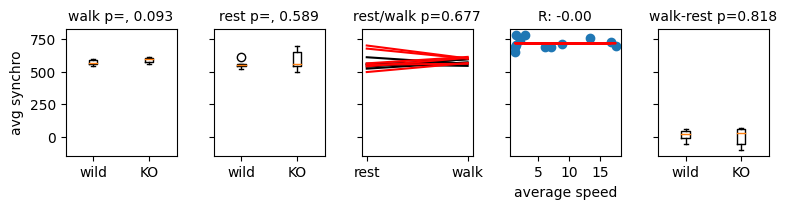

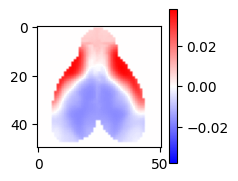

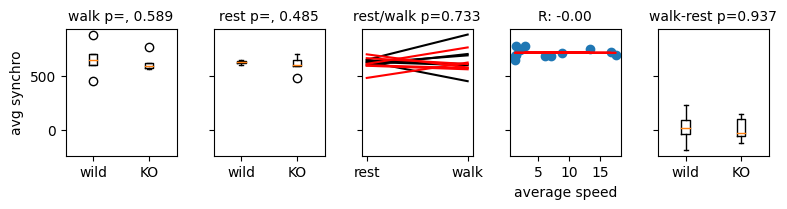

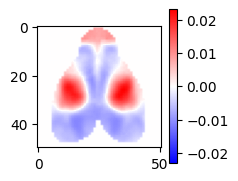

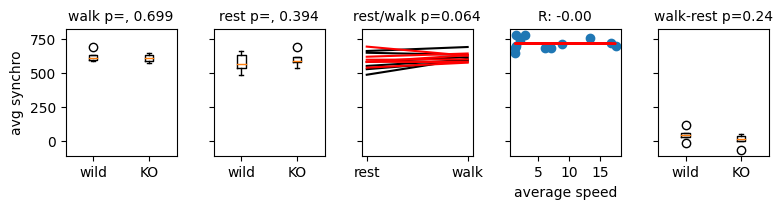

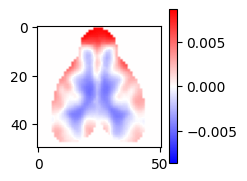

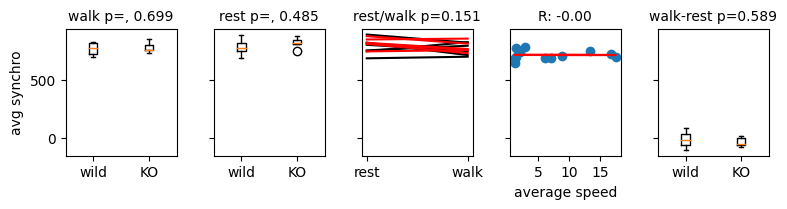

In [15]:
# let us  do average synchro and metastability, avg and std of speed 

n_individuals = len(names+names_knock)
synchro_walk = np.zeros((n_individuals,k))
synchro_rest = np.zeros((n_individuals,k))
synchro_all = np.zeros((n_individuals,k))
meta_walk = np.zeros((n_individuals,k))
meta_rest = np.zeros((n_individuals,k))
meta_all = np.zeros((n_individuals,k))
r_speed_walk = np.zeros((n_individuals,k))
r_speed_rest = np.zeros((n_individuals,k))
r_speed_all = np.zeros((n_individuals,k))
meta_speed_walk = np.zeros((n_individuals,k))
meta_speed_rest = np.zeros((n_individuals,k))
meta_speed_all = np.zeros((n_individuals,k))

for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        timeseries_labels = km.labels_[int(i*end):int((i+1)*end)]==j
        eig_timeseries = np.load(path+name+'_eigenvalue_timeseries.npy')
        speed_timeseries = np.load(path+name+'_reconf_speed.npy')
        
        synchro_walk[i,j] = np.mean(eig_timeseries[np.logical_and(walking,timeseries_labels)])
        synchro_rest[i,j] = np.mean(eig_timeseries[np.logical_and(~walking,timeseries_labels)])
        synchro_all[i,j] = np.mean(eig_timeseries)
        
        meta_walk[i,j] = np.std(eig_timeseries[np.logical_and(walking,timeseries_labels)])
        meta_rest[i,j] = np.std(eig_timeseries[np.logical_and(~walking,timeseries_labels)])
        meta_all[i,j] = np.std(eig_timeseries)
        
        r_speed_walk[i,j] = np.mean(speed_timeseries[np.logical_and(walking,timeseries_labels)])
        r_speed_rest[i,j] = np.mean(speed_timeseries[np.logical_and(~walking,timeseries_labels)])
        r_speed_all[i,j] = np.mean(speed_timeseries)
        
        meta_speed_walk[i,j] = np.std(speed_timeseries[np.logical_and(walking,timeseries_labels)])
        meta_speed_rest[i,j] = np.std(speed_timeseries[np.logical_and(~walking,timeseries_labels)])
        meta_speed_all[i,j] = np.std(speed_timeseries)

do_statistics(centroids,H,W,good_indices,synchro_walk,synchro_rest,synchro_all,'avg synchro',avg_abs_speed)

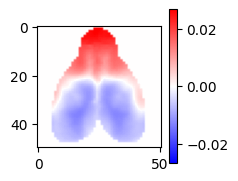

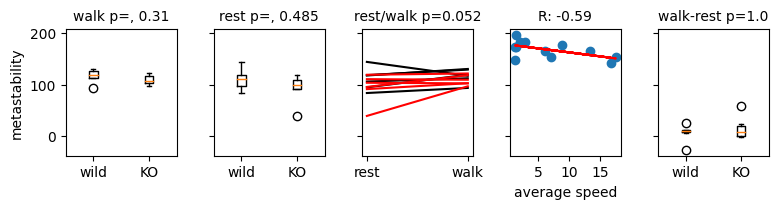

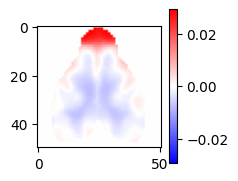

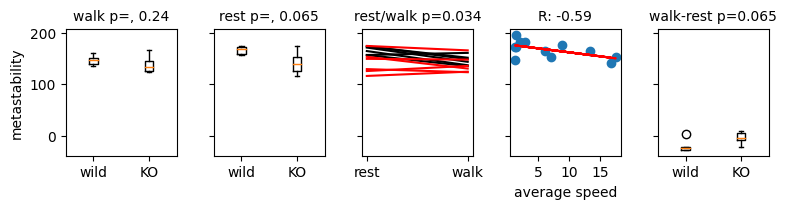

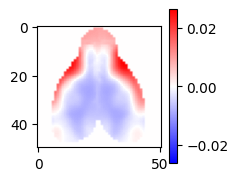

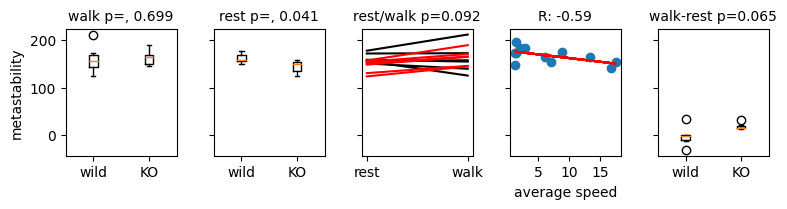

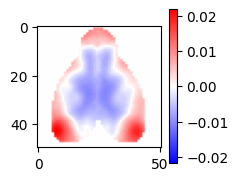

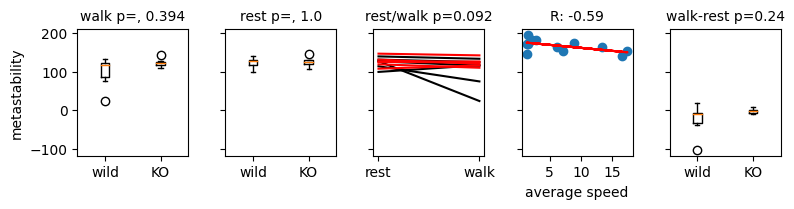

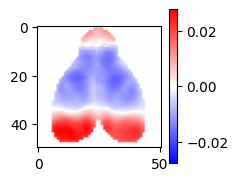

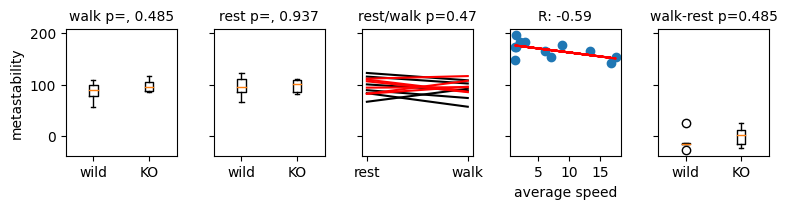

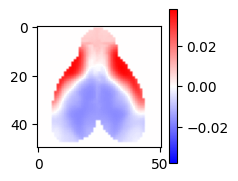

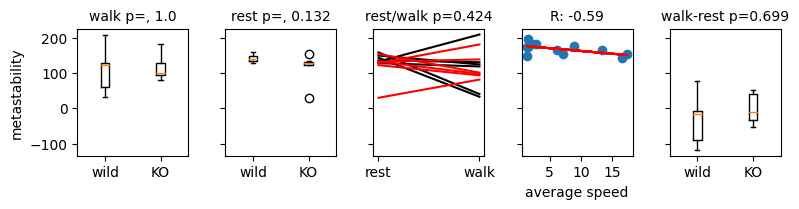

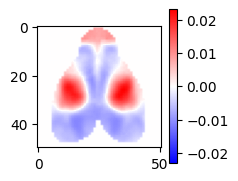

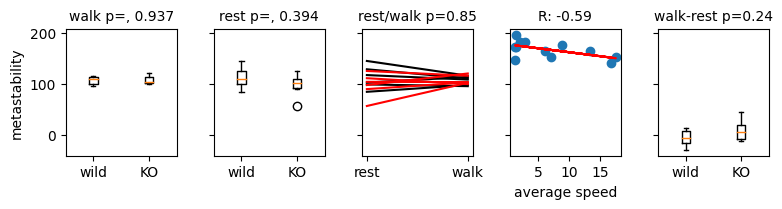

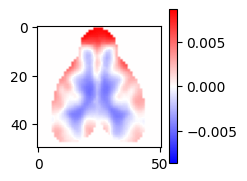

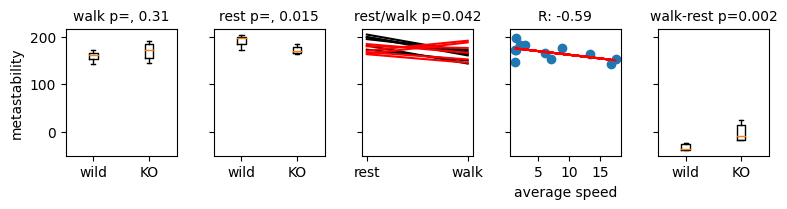

In [16]:
do_statistics(centroids,H,W,good_indices,meta_walk,meta_rest,meta_all,'metastability',avg_abs_speed)

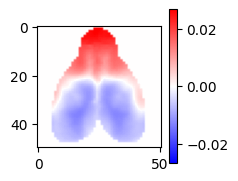

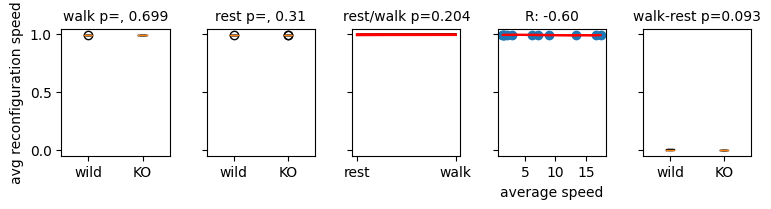

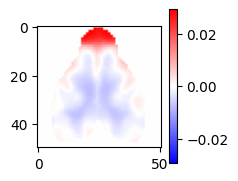

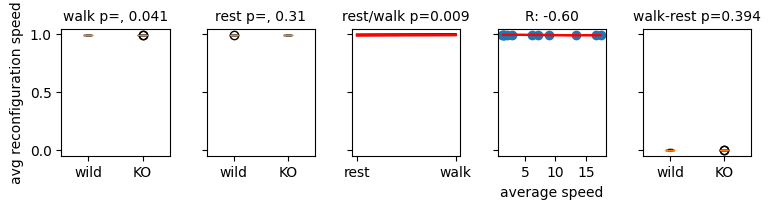

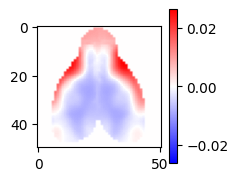

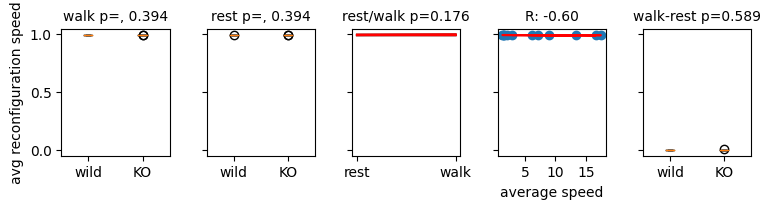

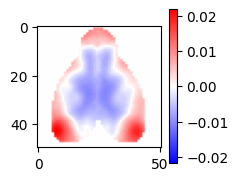

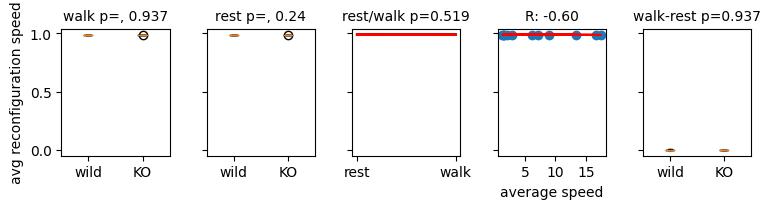

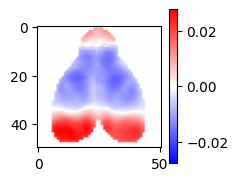

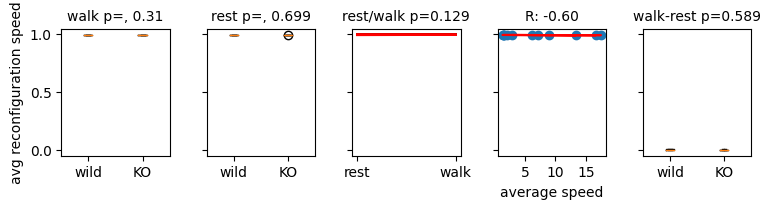

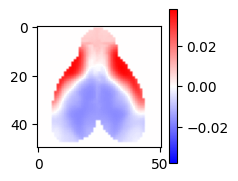

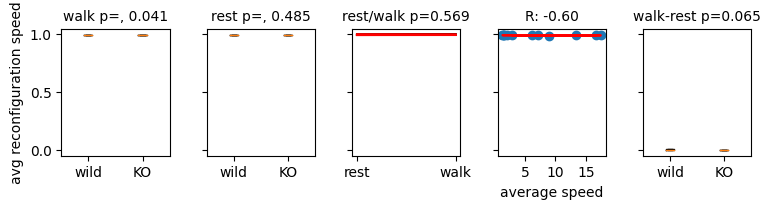

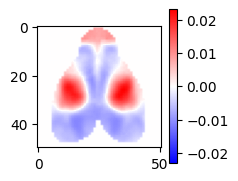

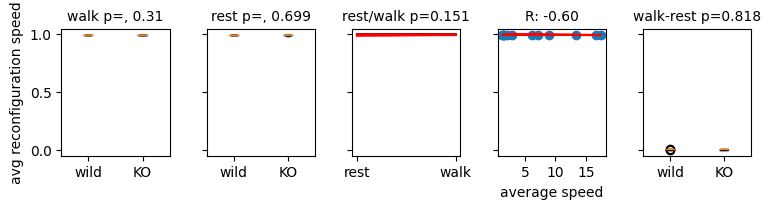

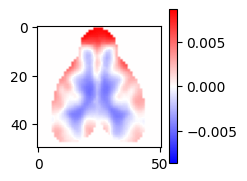

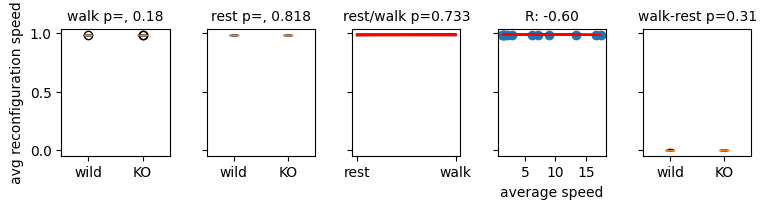

In [17]:
do_statistics(centroids,H,W,good_indices,r_speed_walk,r_speed_rest,r_speed_all,'avg reconfiguration speed',avg_abs_speed)

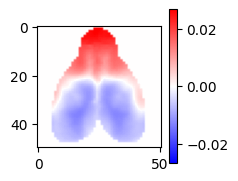

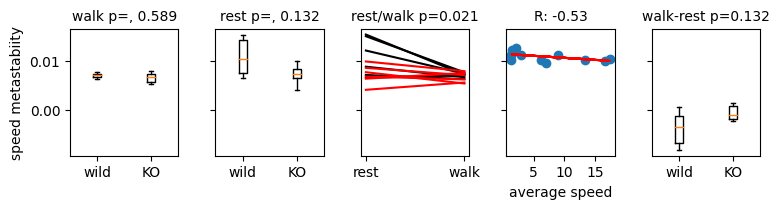

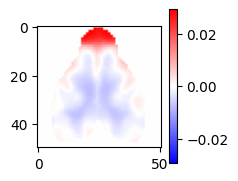

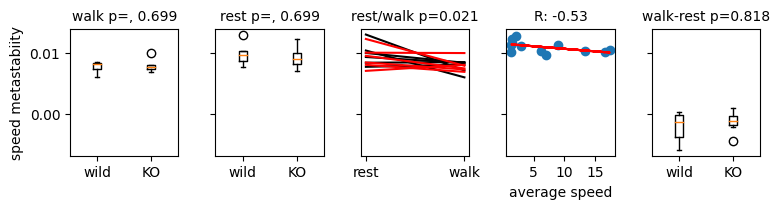

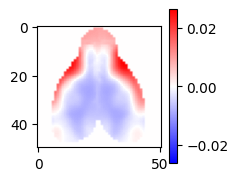

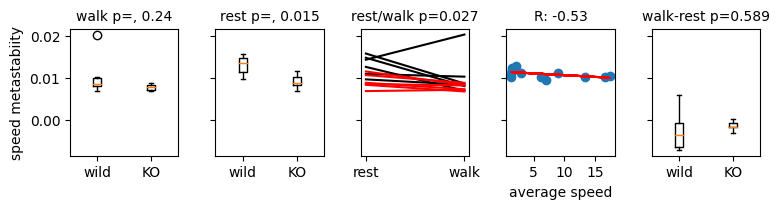

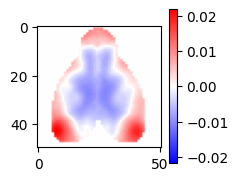

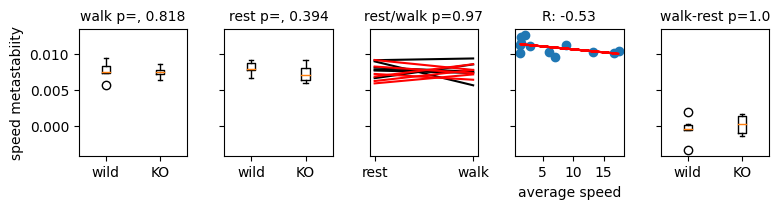

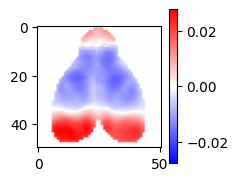

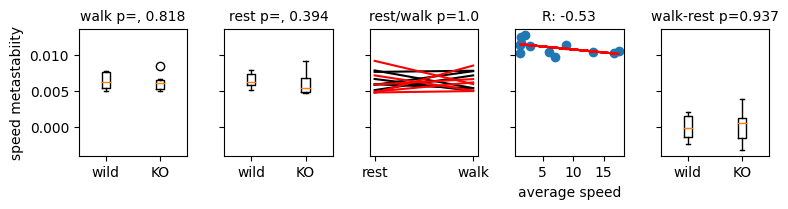

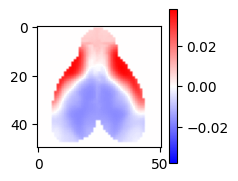

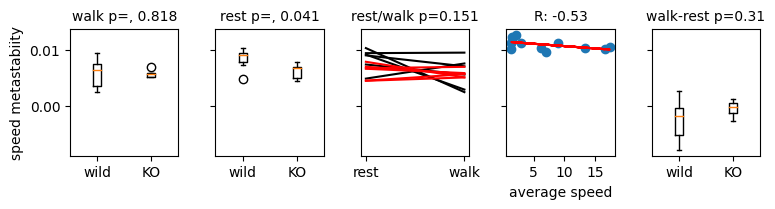

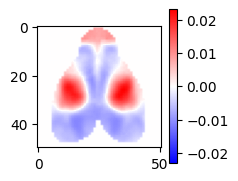

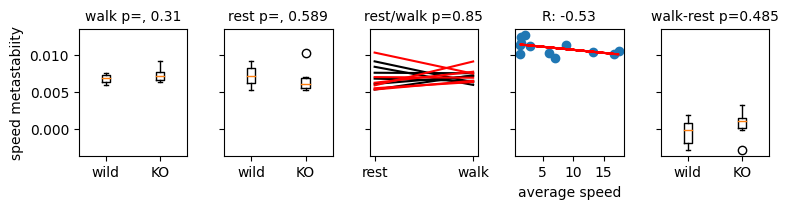

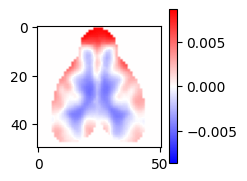

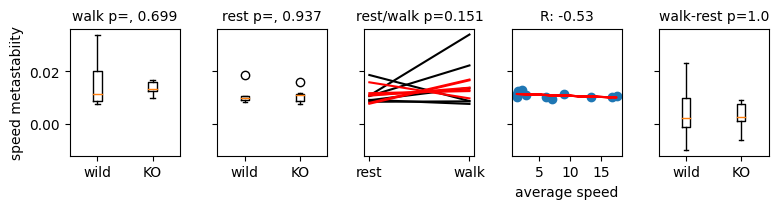

In [18]:
do_statistics(centroids,H,W,good_indices,meta_speed_walk,meta_speed_rest,meta_speed_all,'speed metastabiity',avg_abs_speed)

In [19]:
# try to plot distances to see if we have interesting results: 
# try to use a HMM to explain this - WE WILL DO AS WELL TRANSITIONS 

! pip install hmmlearn

In [20]:
# create graph with transition probabilities. Each row is where I start, each column is where I arrive 
n_mice = len(names+names_knock)


transition_prob_list = np.zeros((n_mice,k,k))
emission_prob_list = np.zeros((n_mice,k))

for i,name in enumerate(names+names_knock):

    timeseries_labels = km.labels_[int(i*end):int((i+1)*end)]
    transition_prob = np.zeros((k,k))
    emission_prob = np.zeros((k,))
    time_total = len(timeseries_labels)
    
    for j in range(time_total-1):
        transition_prob[timeseries_labels[j],timeseries_labels[j+1]] += 1

    #normalize each row with respect to number of observed transitions
    for j in range(k):
        transition_prob[j,:] /= np.sum(timeseries_labels==j)

    # calculate emission probabilities

    walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
    for j in range(k):
        emission_prob[j] = np.sum(walking[timeseries_labels == j])/len(walking[timeseries_labels == j])

    transition_prob_list[i,:,:] = transition_prob
    emission_prob_list[i,:] = emission_prob

In [21]:
# try transitions walk and rest
n_mice = len(names+names_knock)


transition_prob_list_walk = np.zeros((n_mice,k,k))
transition_prob_list_rest = np.zeros((n_mice,k,k))


for i,name in enumerate(names+names_knock):
    
    walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
    timeseries_labels = km.labels_[int(i*end):int((i+1)*end)]
    timeseries_labels_walk = timeseries_labels[walking]
    timeseries_labels_rest = timeseries_labels[~walking]
    transition_prob_walk = np.zeros((k,k))
    transition_prob_rest = np.zeros((k,k))

    time_total_walk = len(timeseries_labels_walk)
    time_total_rest = len(timeseries_labels_rest)

    
    for j in range(time_total_walk-1):
        transition_prob_walk[timeseries_labels_walk[j],timeseries_labels_walk[j+1]] += 1
    #normalize each row with respect to number of observed transitions
    for j in range(k):
        transition_prob_walk[j,:] /= np.sum(timeseries_labels_walk==j)
        
    for j in range(time_total_rest-1):
        transition_prob_rest[timeseries_labels_rest[j],timeseries_labels_rest[j+1]] += 1
    #normalize each row with respect to number of observed transitions
    for j in range(k):
        transition_prob_rest[j,:] /= np.sum(timeseries_labels_rest==j)

    # calculate emission probabilities


    transition_prob_list_walk[i,:,:] = transition_prob_walk
    transition_prob_list_rest[i,:,:] = transition_prob_rest


In [22]:
transition_prob_list_walk

array([[[9.04958678e-01, 2.89256198e-02, 1.23966942e-02, 0.00000000e+00,
         0.00000000e+00, 8.26446281e-03, 1.23966942e-02, 2.89256198e-02],
        [2.02578269e-02, 9.04235727e-01, 1.84162063e-03, 3.68324125e-03,
         0.00000000e+00, 0.00000000e+00, 9.20810313e-03, 6.07734807e-02],
        [4.76190476e-02, 3.17460317e-02, 7.93650794e-01, 0.00000000e+00,
         0.00000000e+00, 1.58730159e-02, 4.76190476e-02, 6.34920635e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.15384615e-01,
         7.69230769e-02, 0.00000000e+00, 0.00000000e+00, 3.07692308e-01],
        [0.00000000e+00, 2.50000000e-02, 0.00000000e+00, 2.50000000e-02,
         9.00000000e-01, 0.00000000e+00, 2.50000000e-02, 2.50000000e-02],
        [0.00000000e+00, 0.00000000e+00, 1.05263158e-01, 0.00000000e+00,
         5.26315789e-02, 7.89473684e-01, 5.26315789e-02, 0.00000000e+00],
        [1.11940299e-02, 2.61194030e-02, 0.00000000e+00, 0.00000000e+00,
         3.73134328e-03, 3.73134328e-03, 8.95

In [23]:
# try statistics walk versys rest

from scipy.stats import wilcoxon
statistics_trans = np.zeros((k,k))

for i in range(k):
    for j in range(k):
        data1 = transition_prob_list_walk[:,i,j]
        data2 = transition_prob_list_rest[:,i,j]
        if np.sum(data1-data2):
            statistics_trans[i,j] = wilcoxon(data1,data2).pvalue
        else:
            statistics_trans[i,j] = 1
        

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [24]:
statistics_trans # COOL WE HAVE STATISTICALLY SIGNIFICANT PATTERN OF TRANSITIONS!

array([[4.88281250e-04, 4.69726562e-01, 4.88281250e-04, 6.18837511e-02,
        2.13222988e-01, 4.88281250e-04, 9.76562500e-04, 4.88281250e-04],
       [3.39355469e-01, 4.88281250e-04, 4.88281250e-04, 2.44140625e-03,
        4.23596318e-01, 2.18242756e-02, 9.76562500e-04, 3.41796875e-03],
       [4.88281250e-04, 1.61132812e-02, 3.41796875e-03, 4.88281250e-03,
        6.12089880e-01, 4.88281250e-04, 4.88281250e-04, 2.44140625e-03],
       [9.27734375e-03, 3.41796875e-03, 4.88281250e-04, 6.83593750e-03,
        4.88281250e-04, 1.08622247e-02, 2.68554688e-02, 1.09863281e-01],
       [2.84168642e-02, 1.76269531e-01, 1.23485272e-01, 6.83593750e-03,
        4.88281250e-03, 6.91042981e-03, 1.76269531e-01, 9.27734375e-03],
       [7.71484375e-02, 3.13938094e-01, 7.71484375e-02, 1.73070921e-01,
        1.39413973e-01, 1.61132812e-02, 9.76562500e-04, 1.23485272e-01],
       [8.50097656e-01, 5.69335938e-01, 1.46484375e-03, 1.39413973e-01,
        4.69726562e-01, 2.09960938e-02, 4.88281250e-04, 5.

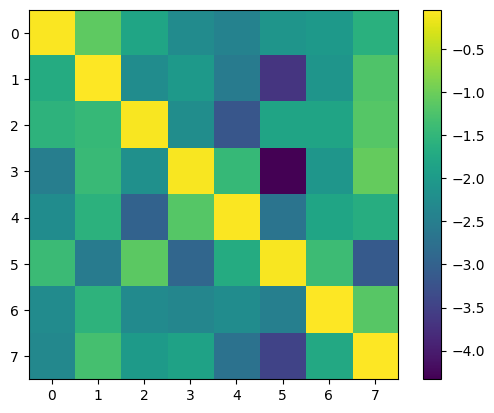

In [25]:
# LET'S THEN SEE THE DIFFERENCES 
plt.imshow(np.log10(np.mean(transition_prob_list_walk,axis=0)))
plt.colorbar()

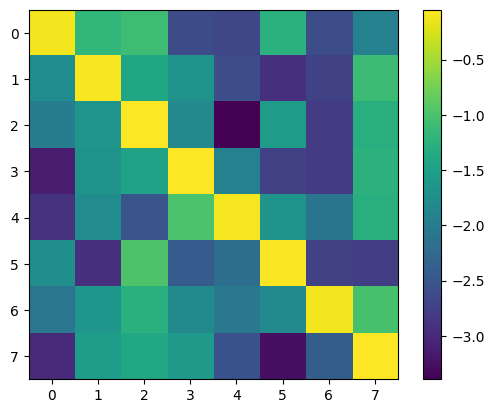

In [26]:
plt.imshow(np.log10(np.mean(transition_prob_list_rest,axis=0)))
plt.colorbar()

In [27]:
# try statistics wild versus ko

from scipy.stats import wilcoxon
statistics_trans = np.zeros((k,k))

for i in range(k):
    for j in range(k):
        statistics_trans[i,j] = wilcoxon(transition_prob_list[0:6,i,j],transition_prob_list[6:12,i,j]).pvalue

statistics_emission = np.zeros((k,))

for i in range(k):
        statistics_emission[i] = wilcoxon(emission_prob_list[0:6,i],emission_prob_list[6:12,i]).pvalue       

In [28]:
# I do now nonparametric testing 

def statistics(data1):
    diff = data1[0:6,:]-data1[6:12,:]
    return np.max(np.abs((np.mean(diff,axis=0)-np.std(diff,axis=0))))

In [29]:
my_statistic=statistics(emission_prob_list)

In [30]:
# i do shuffling 

null_distribution = []

for i in range(10000):
    np.random.shuffle(emission_prob_list)
    null_distribution.append(statistics(emission_prob_list))

In [31]:
threshold = np.percentile(null_distribution,97)
my_statistic>threshold

True

In [32]:
my_statistic

0.748188434773432

In [33]:
threshold

0.7216566979676536

In [34]:
arr = np.arange(12)
emission_prob_list[np.random.shuffle(arr),:]

array([[[0.90191898, 0.88507334, 0.20665742, 0.464701  , 0.76348548,
         0.30211203, 0.90684624, 0.60235355],
        [0.47149461, 0.47260439, 0.02376165, 0.18831823, 0.5745614 ,
         0.0136612 , 0.878287  , 0.2125239 ],
        [0.83375315, 0.89813341, 0.33849969, 0.84544254, 0.9647651 ,
         0.35324675, 0.98438263, 0.8422476 ],
        [0.98772169, 0.96146369, 0.60987831, 0.85933749, 0.95879121,
         0.54205607, 0.96012592, 0.912585  ],
        [0.53662692, 0.63948773, 0.14002933, 0.48197343, 0.8125    ,
         0.20488722, 0.97735573, 0.39291217],
        [0.75060338, 0.78954635, 0.28730881, 0.49118774, 0.63058419,
         0.2       , 0.90480769, 0.73243103],
        [0.73561431, 0.64481707, 0.50188395, 0.48810382, 0.53745928,
         0.26226226, 0.791     , 0.67055189],
        [0.19868637, 0.20717283, 0.01053336, 0.00440977, 0.14869888,
         0.01276882, 0.63657957, 0.08872091],
        [0.96492847, 0.93699904, 0.70131291, 0.66866485, 0.80733945,
         0.

In [35]:
def plot_trans_matrix(transition_prob):

    np.fill_diagonal(transition_prob, 0) #c'è una cosa da discutere su python: certe funzioni alterano il content!

    # Set the color map
    cmap = plt.cm.Blues
    colors = transition_prob_wild/transition_prob.max()
    # Create a figure and axis object
    fig, ax = plt.subplots()
    # Create a table object and add it to the axis
    table = ax.table(cellText=transition_prob.round(3),
                     cellColours=cmap(colors))
    # Set the font size of the table text
    table.set_fontsize(14)
    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()